In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv('Phishing Websites Engineered.csv')

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
lr = LogisticRegression(random_state=42)
svm = SVC(probability=True, random_state=42)
dt = DecisionTreeClassifier(random_state=42)

In [8]:
hard_voting = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('svm', svm),
        ('dt', dt)
    ],
    voting='hard'
)

In [9]:
hard_voting.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('svm', SVC(probability=True, random_state=42)),
                             ('dt', DecisionTreeClassifier(random_state=42))])

In [10]:
y_pred = hard_voting.predict(X_test)

In [11]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9401709401709402

Classification Report:
              precision    recall  f1-score   support

          -1       0.96      0.93      0.94       620
           1       0.92      0.95      0.94       550

    accuracy                           0.94      1170
   macro avg       0.94      0.94      0.94      1170
weighted avg       0.94      0.94      0.94      1170



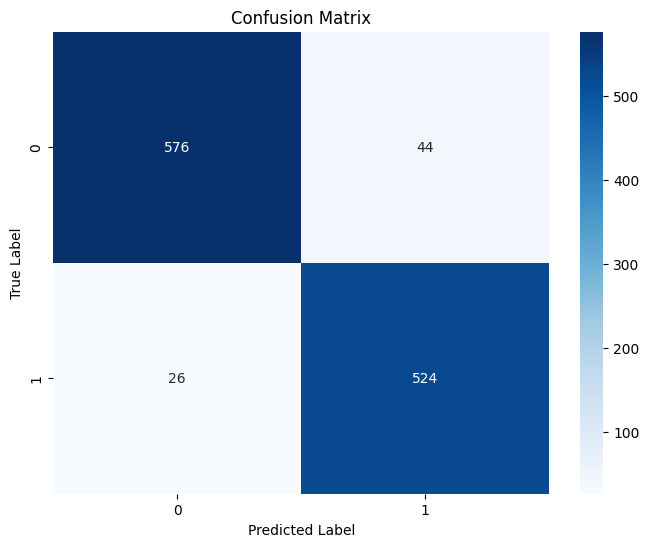

In [12]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# **SHAP**

Computing SHAP for lr


  0%|          | 0/10 [00:00<?, ?it/s]

SHAP Summary Plot - lr


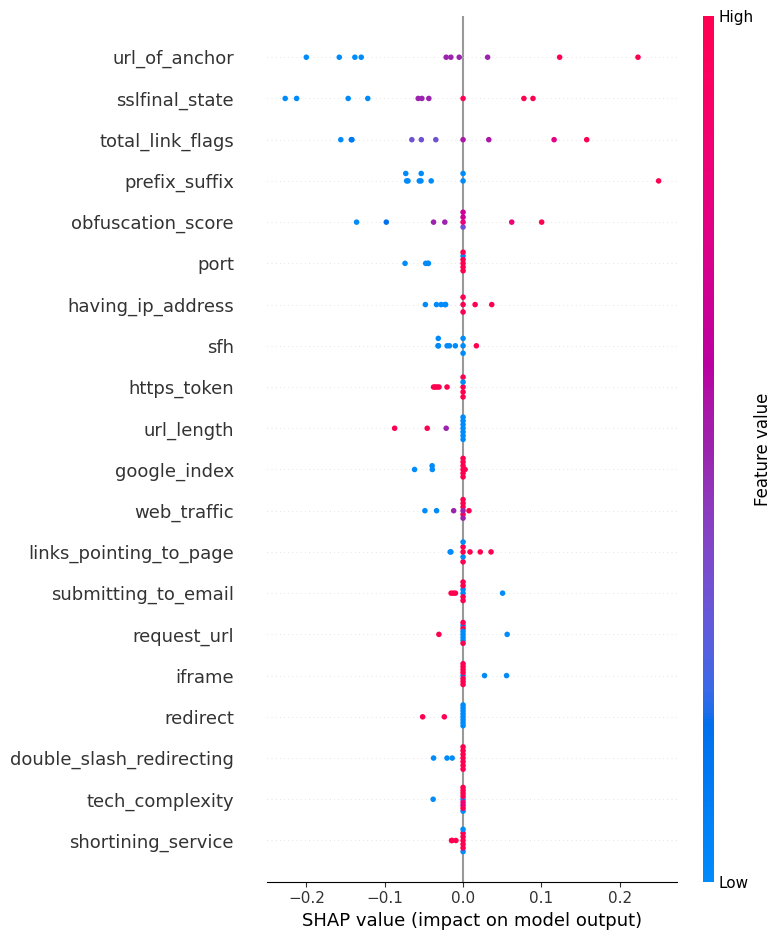

Computing SHAP for svm


  0%|          | 0/10 [00:00<?, ?it/s]

SHAP Summary Plot - svm


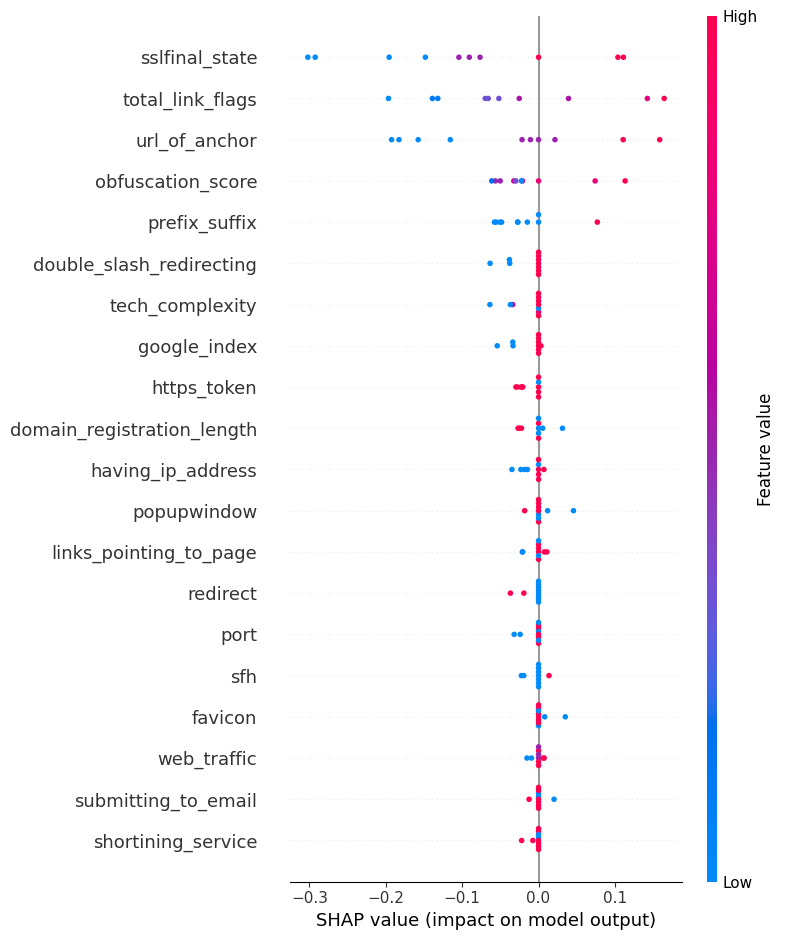

Computing SHAP for dt
SHAP Summary Plot - dt


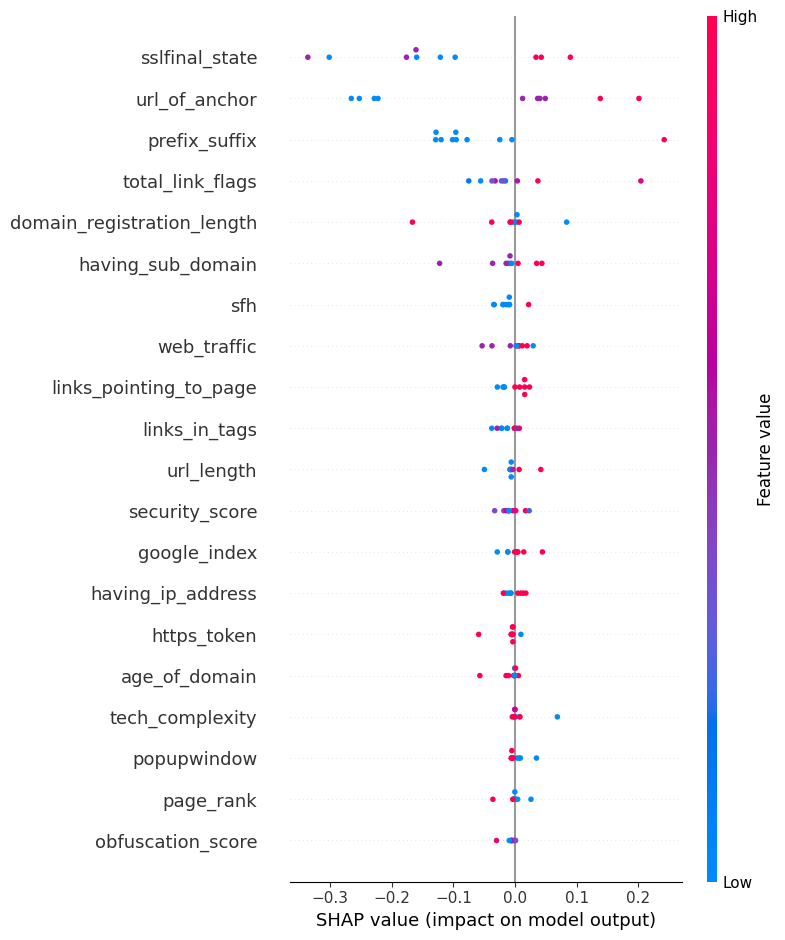

In [13]:
import shap

background = shap.sample(X_train, 100, random_state=42)
sample = X_test.sample(10, random_state=42)
models = hard_voting.named_estimators_
shap_values_dict = {}

for name, model in models.items():
    print(f"Computing SHAP for {name}")
    if name == 'dt':
        explainer = shap.TreeExplainer(model, background)
        shap_values = explainer.shap_values(sample)
    else:
        explainer = shap.KernelExplainer(model.predict_proba, background)
        shap_values = explainer.shap_values(sample)

    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    elif len(shap_values.shape) == 3:
        shap_values = shap_values[:, :, 1]
    elif name == 'dt' and isinstance(shap_values, np.ndarray) and len(shap_values.shape) == 2:
        shap_values = shap_values

    shap_values_dict[name] = shap_values

    print(f"SHAP Summary Plot - {name}")
    shap.summary_plot(shap_values, sample, feature_names=X_train.columns, show=False)
    plt.tight_layout()
    plt.show()

# **LIME**

In [14]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4871c7b5e61d9c6331063771b8d55243ecfe3be76fd567476a96ea2b13b2c347
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [15]:
import lime
import lime.lime_tabular
import numpy as np

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns.tolist(),
    class_names=['Legitimate', 'Phishing'],
    mode='classification'
)

In [16]:
def explain_instance_lime(model, model_name):
    i = np.random.randint(0, X_test.shape[0])
    exp = lime_explainer.explain_instance(
        X_test.iloc[i],
        model.predict_proba,
        num_features=10
    )
    print(f"\n🔍 LIME Explanation for model: {model_name} on instance {i}")
    exp.show_in_notebook(show_table=True)
    return exp

In [17]:
explain_instance_lime(hard_voting.estimators_[0], 'Logistic Regression')
explain_instance_lime(hard_voting.estimators_[1], 'SVC')
explain_instance_lime(hard_voting.estimators_[2], 'Decision Tree')

/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.


🔍 LIME Explanation for model: Logistic Regression on instance 1033


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.


🔍 LIME Explanation for model: SVC on instance 348


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.


🔍 LIME Explanation for model: Decision Tree on instance 929


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series._

# **Permutation Feature Importance**

Top 5 Features by PFI:
              Feature  Importance
7      sslfinal_state    0.081709
13      url_of_anchor    0.061368
30   total_link_flags    0.048376
5       prefix_suffix    0.033932
32  obfuscation_score    0.013419


<Figure size 1000x600 with 0 Axes>

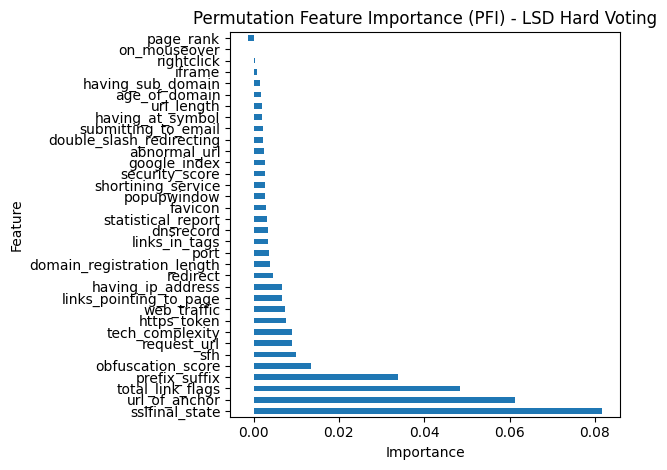

In [18]:
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

pfi_result = permutation_importance(hard_voting, X_test, y_test, n_repeats=10, random_state=42)
pfi_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': pfi_result.importances_mean
}).sort_values(by='Importance', ascending=False)

print("Top 5 Features by PFI:")
print(pfi_df.head())

plt.figure(figsize=(10, 6))
pfi_df.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title("Permutation Feature Importance (PFI) - LSD Hard Voting")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# **LOFO Importance**

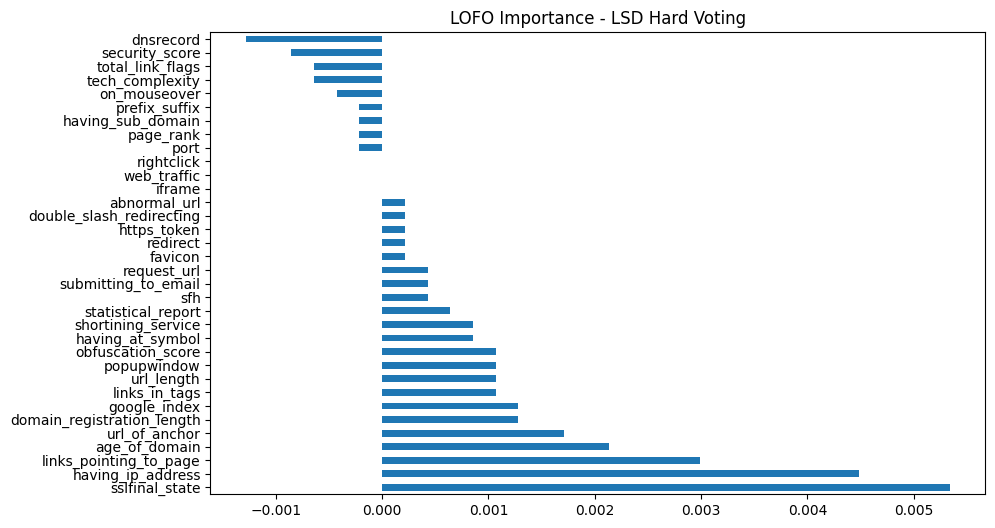

In [20]:
from sklearn.model_selection import cross_val_score
baseline= cross_val_score(hard_voting, X_train, y_train, cv=5).mean()

lofo_scores = {}
for col in X_train.columns:
    X_lofo = X_train.drop(col, axis=1)
    lofo_score = cross_val_score(hard_voting, X_lofo, y_train, cv=5).mean()
    lofo_scores[col] = baseline - lofo_score

lofo_df = pd.Series(lofo_scores).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
lofo_df.plot(kind='barh')
plt.title("LOFO Importance - LSD Hard Voting")
plt.show()

In [21]:
print("\nTop 5 Features by LOFO Importance:")
print(lofo_df.head())


Top 5 Features by LOFO Importance:
sslfinal_state            0.005343
having_ip_address         0.004488
links_pointing_to_page    0.002991
age_of_domain             0.002137
url_of_anchor             0.001710
dtype: float64
